# Figure 4: Learning Dend-I weights for Dendritic Target Propagation

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import h5py

import EIANN as eiann
import EIANN.utils as ut
from EIANN.generate_figures import *

eiann.update_plot_defaults()

In [2]:
figure_name = "Fig4_learning_dendI"
model_list = ["bpLike_WT_fixedDend", "bpLike_WT_localBP", "bpLike_WT_hebbdend"]
model_dict_all = load_model_dict()
generate_hdf5_all_seeds(model_list, model_dict_all, variables_to_save=["average_pop_activity_dict", "metrics_dict", "angle_vs_bp", "dendritic_state"], recompute=None)

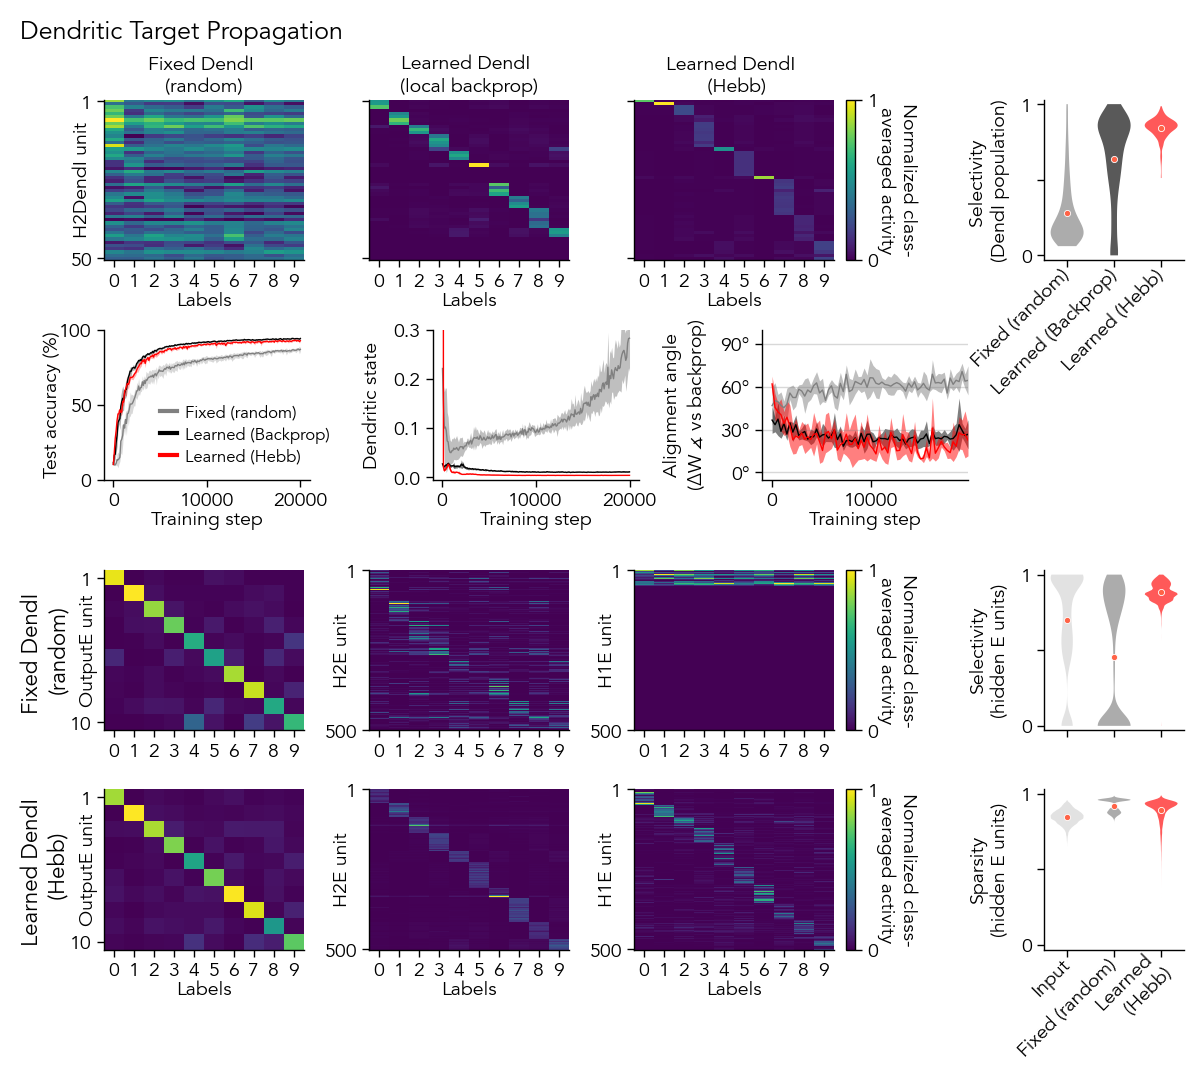

In [5]:
fig = plt.figure(figsize=(6, 5))

axes1 = gs.GridSpec(nrows=4, ncols=5, figure=fig,            
                    left=0.08,right=0.98,
                    bottom=0.07, top=0.92,
                    wspace=0.4, hspace=0.35, 
                    height_ratios=[1, 1.2, 1, 1], width_ratios=[1, 1, 1, 0.4, 0.7])
ax_dend_selectivity = fig.add_subplot(axes1[0, 4])
ax_selectivity      = fig.add_subplot(axes1[2, 4])
ax_sparsity         = fig.add_subplot(axes1[3, 4])

axes2 = gs.GridSpec(nrows=1, ncols=3, figure=fig,
                    left=0.08,right=0.8,
                    bottom=0.54, top=0.69,
                    wspace=0.6, hspace=0.3)
ax_accuracy    = fig.add_subplot(axes2[0])
ax_dendstate   = fig.add_subplot(axes2[1])
ax_angle       = fig.add_subplot(axes2[2])

root_dir = ut.get_project_root()
model_dict_all["bpLike_WT_hebbdend"]["display_name"] = "Learned DendI \n (Hebb)"
model_dict_all["bpLike_WT_hebbdend"]["label"] = "Learned (Hebb)"

for col, model_key in enumerate(model_list):
    model_dict = model_dict_all[model_key]
    network_name = model_dict['config'].split('.')[0]
    hdf5_path = root_dir + f"/EIANN/data/model_hdf5_plot_data/plot_data_{network_name}.h5"
    with h5py.File(hdf5_path, 'r') as f:
        data_dict = f[network_name]
        # print(f"Generating plots for {model_dict['label']}")
        
        population = 'H2DendI'
        example_seed = model_dict['seeds'][0] # example seed to plot

        ######################################
        # Example heatmaps for E populations
        ######################################
        ax = fig.add_subplot(axes1[0, col])
        average_pop_activity_dict = data_dict[example_seed]['average_pop_activity_dict']
        num_units = average_pop_activity_dict[population].shape[1]
        eiann.plot_batch_accuracy_from_data(average_pop_activity_dict, population=population, sort=True, ax=ax, cbar=False)
        if col==len(model_list)-1:
            pos = ax.get_position()                
            cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.008, pos.height])                
            cbar = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap='viridis', orientation='vertical')
            cbar.set_label('Normalized class-\naveraged activity', labelpad=14, rotation=270)
            cbar.set_ticks([0, 1])

        ax.set_yticks([0,num_units-1])
        ax.set_yticklabels([1,num_units])
        ax.set_ylabel(f'{population} unit', labelpad=-8)
        ax.set_xlabel(ax.get_xlabel(), labelpad=0)
        ax.set_title(model_dict["display_name"], pad=3)
        if col>0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            
        ######################################
        # Model metrics
        ######################################
        plot_accuracy_all_seeds(data_dict, model_dict, ax=ax_accuracy)
        legend = ax_accuracy.legend(ncol=1, bbox_to_anchor=(0.2, 0.6), loc='upper left', fontsize=6)
        for line in legend.get_lines():
            line.set_linewidth(1.5)

        plot_dendritic_state_all_seeds(data_dict, model_dict, ax=ax_dendstate)
        plot_angle_vs_bp_all_seeds(data_dict, model_dict, ax=ax_angle)

        populations_to_plot = [population for population in data_dict[example_seed]['average_pop_activity_dict'] if 'DendI' in population]
        plot_metric_all_seeds(data_dict, model_dict, populations_to_plot=populations_to_plot, ax=ax_dend_selectivity, metric_name='selectivity', plot_type='violin', plot_input=False)
        ax_dend_selectivity.set_ylabel(f"Selectivity \n(DendI population)")


        ######################################
        # Representations of E populations
        ######################################
        subpanel_config = {"bpLike_WT_fixedDend": {"row": 2, "remove_xlabel": True},
                            "bpLike_WT_hebbdend": {"row": 3, "remove_xlabel": False}}
        if model_key in subpanel_config:
            # Plot activity heatmaps of each population to the test dataset
            cfg = subpanel_config[model_key]
            average_pop_activity_dict = data_dict[example_seed]['average_pop_activity_dict']
            for i, population in enumerate(["OutputE", "H2E", "H1E"]):
                ax = fig.add_subplot(axes1[cfg["row"], i])
                eiann.plot_batch_accuracy_from_data(average_pop_activity_dict, population=population, sort=True, ax=ax, cbar=False)
                num_units = average_pop_activity_dict[population].shape[1]
                ax.set_yticks([0,num_units-1])
                ax.set_yticklabels([1,num_units])
                ax.set_ylabel(f'{population} unit', labelpad=-10)
                ax.set_xlabel(ax.get_xlabel(), labelpad=0)
                if i==0:
                    ax.set_title(model_dict['display_name'], rotation=90, x=-0.29, y=0.4, va='center', fontsize=8)
                if cfg["remove_xlabel"]:
                    ax.set_xlabel('')

                if i==2:
                    pos = ax.get_position()                
                    cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.008, pos.height])                
                    cbar = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap='viridis', orientation='vertical')
                    cbar.set_label('Normalized class-\naveraged activity', labelpad=14, rotation=270)
                    cbar.set_ticks([0, 1])

            # Plot sparsity and selectivity of hidden layers
            if model_key == "bpLike_WT_hebbdend":
                model_dict_all["bpLike_WT_hebbdend"]["label"] = "Learned \n(Hebb)"
            populations_to_plot = ['H1E', 'H2E']
            plot_metric_all_seeds(data_dict, model_dict, populations_to_plot=populations_to_plot, ax=ax_selectivity, metric_name='selectivity', plot_type='violin', side='both')
            plot_metric_all_seeds(data_dict, model_dict, populations_to_plot=populations_to_plot, ax=ax_sparsity, metric_name='sparsity', plot_type='violin', side='both')
            ax_selectivity.set_ylabel(f"Selectivity\n(hidden E units)")
            ax_selectivity.set_xticklabels([])
            ax_sparsity.set_ylabel(f"Sparsity\n(hidden E units)")

fig.suptitle("Dendritic Target Propagation", x=0.01, y=1., fontsize=9, ha='left')

fig.savefig(f"{root_dir}/EIANN/figures/{figure_name}.png", dpi=300)
fig.savefig(f"{root_dir}/EIANN/figures/{figure_name}.svg", dpi=300)